In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from merge_datasets import *

# Here we merge and investigate the core datasets pre-processed in `process_standardized_cores.py` and `process_sumup_cores.py`.

First we load the datasets. You can choose whether or not to re-run the pre-processing. We recommend removing the duplicates; only a few are removed.

In [22]:
merged_df, duplicates_df, sumup_df, std_df = merge_datasets(do_run_sumup_processing=False, do_run_std_processing=False, drop_duplicates=True, return_df=True)

Loading sumup data from file... ../data/sumup/processed/sumup_550_830_density_depths_greenland.csv

Loading SUMUP dataset from ../data/sumup/processed/sumup_550_830_density_depths_greenland.csv
Loaded 123 SUMUP records
SUMUP columns: ['core_name', 'profile_key', 'date', 'region', 'latitude', 'longitude', 'elevation', 'citation', 'depth_to_550', 'failed_fit_550', 'r2_550', 'depth_to_830', 'failed_fit_830', 'r2_830', 'year', 'source', 'source_doi']
Loading sumup data from file... ../data/PKM/processed/PKM_550_830_density_depths_greenland.csv

Loading standardized dataset from ../data/PKM/processed/PKM_550_830_density_depths_greenland.csv
Loaded 62 standardized records
Standardized columns: ['core_name', 'latitude', 'longitude', 'elevation', 'year', 'depth_to_550', 'depth_to_830', 'r2_550', 'r2_830', 'failed_fit_550', 'failed_fit_830', 'source', 'method', 'citation', 'measurement_count', 'source_file', 'region']

Identifying duplicates...
Found 21 potential duplicate pairs

Creating final

KeyError: "['failed_550', 'failed_830'] not in index"

We can take a look at the locations of the cores by dataset

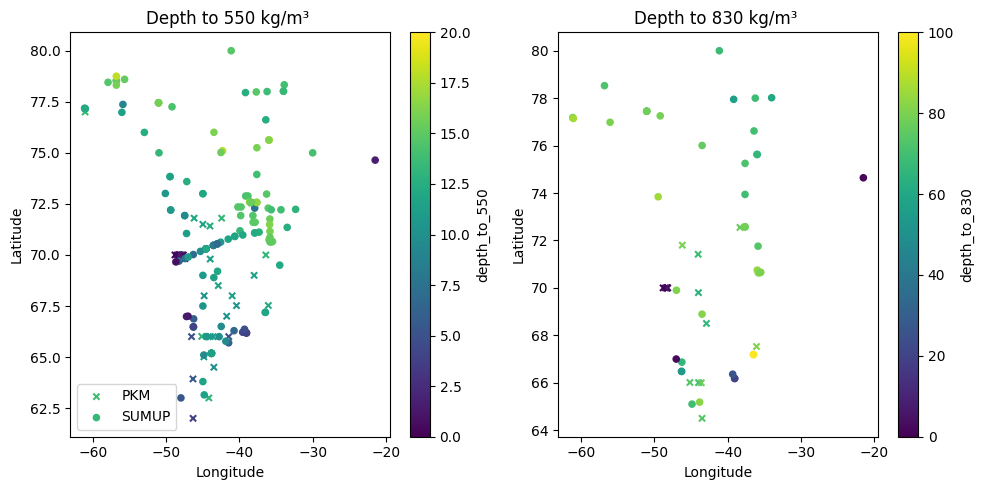

In [47]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10, 5))

merged_df[merged_df['source']=='PKM standardized cores'].plot.scatter(x='longitude', y='latitude', c='depth_to_550', marker='x', title='Depth to 550 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[0],vmin=0,vmax=20, colorbar=False, label="PKM")
merged_df[merged_df['source']=='PKM standardized cores'].plot.scatter(x='longitude', y='latitude', c='depth_to_830', marker='x', title='Depth to 830 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[1],vmin=0,vmax=100, colorbar=False)

merged_df[merged_df['source']=='SUMUP 2024'].plot.scatter(x='longitude', y='latitude', c='depth_to_550', title='Depth to 550 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[0], marker='o',vmin=0,vmax=20, label="SUMUP")
merged_df[merged_df['source']=='SUMUP 2024'].plot.scatter(x='longitude', y='latitude', c='depth_to_830', title='Depth to 830 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[1], marker='o',vmin=0,vmax=100)

plt.tight_layout()

## We often want to find the FDM points that are closest to the cores and create a pointlist of those.

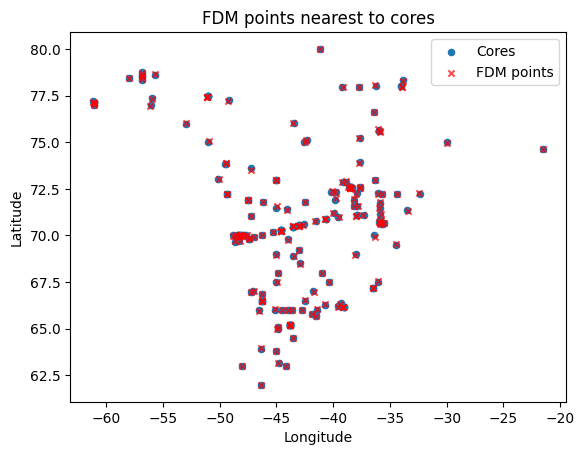

In [57]:
save_pointlist = False

# import fdm reference list
path_to_fdm_locations = "../../reference/FGRN055/"
pointlist_df = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude"],usecols=[0,1])

# create a list of the core locations
core_locations = merged_df[['latitude','longitude']].to_numpy()

df = pointlist_df

xs = []; distances = []  # distance between the pair of points
for point in core_locations:

    assert len(point) == 2, "``points`` should be a tuple or list of tuples (lat, lon)"

    p_lat, p_lon = point
    # Find absolute difference between requested point and the grid coordinates.
    abslat = np.abs(df.latitude - p_lat)
    abslon = np.abs(df.longitude - p_lon)

    # Create grid of the maximum values of the two absolute grids
    c = np.maximum(abslon, abslat)

    # Find location where lat/lon minimum absolute value intersects
    x = np.where(c == np.min(c))[0][0]
    xs.append(x)

    # Matched Grid lat/lon
    g_lat = df.iloc[x,:].latitude
    g_lon = df.iloc[x,:].longitude

    R = 6373.0  # approximate radius of earth in km

    lat1 = np.deg2rad(p_lat); lon1 = np.deg2rad(p_lon)
    lat2 = np.deg2rad(g_lat); lon2 = np.deg2rad(g_lon)
    dlon = lon2 - lon1; dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distances.append(distance)

fig, ax = plt.subplots()

merged_df.plot.scatter(x='longitude', y='latitude', label='Cores', ax=ax)
pointlist_df.loc[xs].plot.scatter(x='longitude', y='latitude', color='red', marker='x', alpha=0.7, title='FDM points nearest to cores', xlabel='Longitude', ylabel='Latitude',ax=ax, label='FDM points')


if save_pointlist:
    output_path = "../merged/pointlist_from_cores_2025.csv"
    pointlist_near_cores = pointlist_df.loc[xs].index.values
    np.savetxt(output_path, pointlist_near_cores, fmt='%d')